212039 - Muhammad Faizan

BSCS-8B

Task 3

Full Custom CNN Code (PyTorch)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to dataset
data_dir = '/content/Dataset/DataSet'

# =====================
# 🔁 Transforms & Data
# =====================
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Smaller size to speed up training
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


Using device: cuda


Custom CNN Model Architecture

In [2]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()

        # 🧱 Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 🧱 Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )

        # 🧱 Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Global-like pooling
        )

        # 🧠 Classification Block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)  # Multi-class
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

# Instantiate model
model = CustomCNN(num_classes=4).to(device)


Train the Model

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc.append(correct / total)
        train_loss.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_total, val_correct, val_epoch_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_epoch_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc.append(val_correct / val_total)
        val_loss.append(val_epoch_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_acc, val_acc, train_loss, val_loss

# Train
train_acc, val_acc, train_loss, val_loss = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)


Epoch 1: Train Acc: 0.7603, Val Acc: 0.9000
Epoch 2: Train Acc: 0.7937, Val Acc: 0.8815
Epoch 3: Train Acc: 0.8262, Val Acc: 0.8741
Epoch 4: Train Acc: 0.8349, Val Acc: 0.8556
Epoch 5: Train Acc: 0.8381, Val Acc: 0.8926
Epoch 6: Train Acc: 0.8532, Val Acc: 0.9222
Epoch 7: Train Acc: 0.8714, Val Acc: 0.8370
Epoch 8: Train Acc: 0.8524, Val Acc: 0.8852
Epoch 9: Train Acc: 0.8754, Val Acc: 0.9259
Epoch 10: Train Acc: 0.8571, Val Acc: 0.9074


 Plot Metrics

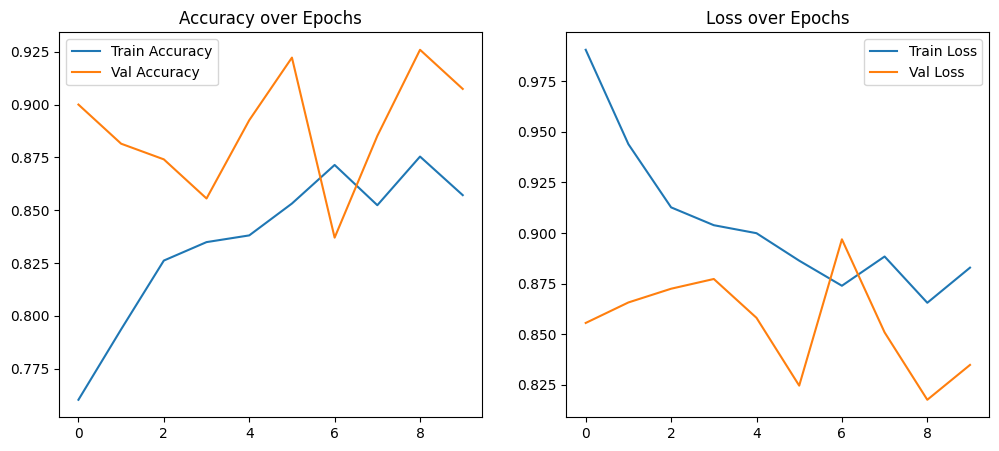

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

Test & Evaluate

Precision: 0.8987974987974988
Recall (Sensitivity): 0.8925925925925926
F1-score: 0.8939635576894521
Specificity per class: [np.float64(0.9888888888888889), np.float64(0.9800995024875622), np.float64(0.9547738693467337), np.float64(0.9391304347826087)]


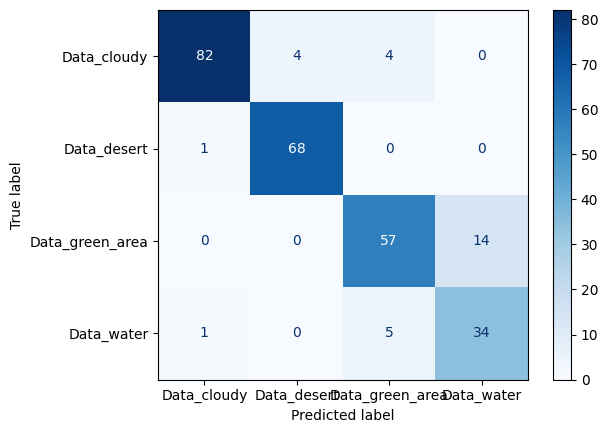

In [5]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues')

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("Precision:", report['weighted avg']['precision'])
print("Recall (Sensitivity):", report['weighted avg']['recall'])
print("F1-score:", report['weighted avg']['f1-score'])

# Specificity Calculation
specificity = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))
print("Specificity per class:", specificity)